<a href="https://colab.research.google.com/github/musaal/AI_teacher/blob/main/Enefit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Enfit energy

## **Project Overview: Forecasting Energy Consumption & Production in Estonia**  

This project aims to predict the electricity consumption and production of Estonian energy customers with installed solar panels. The dataset includes energy usage patterns, weather data, electricity and gas prices, and solar panel capacity information. The goal is to develop an accurate time series forecasting model using machine learning.  

### **Key Data Insights**  
- **Energy Data**: Consumption and production values categorized by county, business type, and contract type.  
- **Weather Data**: Includes temperature, wind speed, cloud cover, and solar radiation forecasts.  
- **Market Prices**: Electricity and natural gas prices available at the time of forecasting.  
- **Temporal Structure**: Data follows an hourly time convention in EET/EEST, aligning with real-world forecasting conditions.  

This project leverages historical trends and real-time weather conditions to enhance forecasting accuracy, benefiting energy providers and consumers in optimizing energy usage.  



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! cd /content/drive
!ls drive/MyDrive/eneft/predict-energy-behavior-of-prosumers

client.csv		    historical_weather.csv
county_id_to_name_map.json  m.py
electricity_prices.csv	    public_timeseries_testing_util.py
enefit			    train.csv
example_test_files	    train_df.csv
forecast_weather.csv	    Untitled-1.ipynb
gas_prices.csv		    weather_station_to_county_mapping.csv


In [4]:
# Replace '...' with the actual file paths
import pandas as pd
train_df = pd.read_csv('drive/MyDrive/eneft/predict-energy-behavior-of-prosumers/train.csv')
client_df = pd.read_csv('drive/MyDrive/eneft/predict-energy-behavior-of-prosumers/client.csv')
gas_prices_df = pd.read_csv('drive/MyDrive/eneft/predict-energy-behavior-of-prosumers/gas_prices.csv')
electricity_prices_df = pd.read_csv('drive/MyDrive/eneft/predict-energy-behavior-of-prosumers/electricity_prices.csv')
forecast_weather_df = pd.read_csv('drive/MyDrive/eneft/predict-energy-behavior-of-prosumers/forecast_weather.csv')
historical_weather = pd.read_csv('drive/MyDrive/eneft/predict-energy-behavior-of-prosumers/historical_weather.csv')


In [5]:
train_df.head(1)

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0


In [6]:
client_df.head(1)

,product_type,county,eic_count,installed_capacity,is_business,date,data_block_id
0,1,0,108,952.89,0,2021-09-01,2


In [7]:
electricity_prices_df.head(1)

,forecast_date,euros_per_mwh,origin_date,data_block_id
0,2021-09-01 00:00:00,92.51,2021-08-31 00:00:00,1


In [8]:
gas_prices_df.head(1)

,forecast_date,lowest_price_per_mwh,highest_price_per_mwh,origin_date,data_block_id
0,2021-09-01,45.23,46.32,2021-08-31,1


In [9]:
forecast_weather_df.head(1)

,latitude,longitude,origin_datetime,hours_ahead,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,data_block_id,forecast_datetime,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation
0,57.6,21.7,2021-09-01 02:00:00,1,15.655786,11.553613,0.904816,0.019714,0.0,0.905899,-0.411328,-9.106137,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0


In [10]:
historical_weather.head(1)

,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,data_block_id
0,2021-09-01 00:00:00,14.2,11.6,0.0,0.0,1015.9,31,31,0,11,7.083333,8,0.0,0.0,0.0,57.6,21.7,1.0


In [11]:
train_df["is_consumption"].value_counts()

,count
is_consumption,
0,1009176
1,1009176


In [ ]:
forecast_weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3424512 entries, 0 to 3424511
Data columns (total 18 columns):
 #   Column                             Dtype  
---  ------                             -----  
 0   latitude                           float64
 1   longitude                          float64
 2   origin_datetime                    object 
 3   hours_ahead                        int64  
 4   temperature                        float64
 5   dewpoint                           float64
 6   cloudcover_high                    float64
 7   cloudcover_low                     float64
 8   cloudcover_mid                     float64
 9   cloudcover_total                   float64
 10  10_metre_u_wind_component          float64
 11  10_metre_v_wind_component          float64
 12  data_block_id                      int64  
 13  forecast_datetime                  object 
 14  direct_solar_radiation             float64
 15  surface_solar_radiation_downwards  float64
 16  snowfall          

In [14]:
def dataset(data,col,tar):
  z = data[col] == tar
  data[z]
  return data[z]



Based on our investigation, the dataset comprises 122 unique profiles. Each profile is classified by the "is_consumption" flag, distinguishing energy consumers from producers. This segmentation is key for developing tailored forecasting models that address the different behaviors of each group

In [16]:
dataset(train_df,"data_block_id",2)

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
5856,0,0,1,0.793,0,2021-09-03 00:00:00,2,5856,0
5857,0,0,1,107.129,1,2021-09-03 00:00:00,2,5857,0
5858,0,0,2,0.000,0,2021-09-03 00:00:00,2,5858,1
5859,0,0,2,19.630,1,2021-09-03 00:00:00,2,5859,1
5860,0,0,3,0.977,0,2021-09-03 00:00:00,2,5860,2
...,...,...,...,...,...,...,...,...,...
8779,15,0,3,71.039,1,2021-09-03 23:00:00,2,8779,58
8780,15,1,1,0.100,0,2021-09-03 23:00:00,2,8780,59
8781,15,1,1,24.501,1,2021-09-03 23:00:00,2,8781,59
8782,15,1,3,0.000,0,2021-09-03 23:00:00,2,8782,60


In [21]:
test = dataset(train_df,"data_block_id",2)

test[test["prediction_unit_id"] == 5 ].sample(8)

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
7087,0,1,3,5751.677,1,2021-09-03 10:00:00,2,7087,5
7330,0,1,3,1817.931,0,2021-09-03 12:00:00,2,7330,5
6842,0,1,3,102.037,0,2021-09-03 08:00:00,2,6842,5
7575,0,1,3,5092.123,1,2021-09-03 14:00:00,2,7575,5
7086,0,1,3,1478.183,0,2021-09-03 10:00:00,2,7086,5
8428,0,1,3,0.504,0,2021-09-03 21:00:00,2,8428,5
6354,0,1,3,0.298,0,2021-09-03 04:00:00,2,6354,5
8551,0,1,3,6002.349,1,2021-09-03 22:00:00,2,8551,5


In [ ]:
dataset(client_df,"data_block_id",2)

,product_type,county,eic_count,installed_capacity,is_business,date,data_block_id
0,1,0,108,952.89,0,2021-09-01,2
1,2,0,17,166.40,0,2021-09-01,2
2,3,0,688,7207.88,0,2021-09-01,2
3,0,0,5,400.00,1,2021-09-01,2
4,1,0,43,1411.00,1,2021-09-01,2
...,...,...,...,...,...,...,...
56,3,14,67,3114.60,1,2021-09-01,2
57,1,15,10,83.20,0,2021-09-01,2
58,3,15,61,918.20,0,2021-09-01,2
59,1,15,7,325.00,1,2021-09-01,2


In [ ]:
dataset(forecast_weather_df,"data_block_id",2)

,latitude,longitude,origin_datetime,hours_ahead,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,data_block_id,forecast_datetime,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation
5376,57.6,21.7,2021-09-02 02:00:00,1,13.443628,6.663721,0.0,0.283615,0.605011,0.647308,-0.491737,-8.771450,2,2021-09-02 03:00:00,0.0,0.0,0.0,0.000000
5377,57.6,22.2,2021-09-02 02:00:00,1,10.725366,5.615137,0.0,0.162018,0.246216,0.284485,0.253747,-3.621059,2,2021-09-02 03:00:00,0.0,0.0,0.0,0.000000
5378,57.6,22.7,2021-09-02 02:00:00,1,12.716211,6.490259,0.0,0.131592,0.103241,0.154175,1.267174,-7.223843,2,2021-09-02 03:00:00,0.0,0.0,0.0,0.000000
5379,57.6,23.2,2021-09-02 02:00:00,1,13.030664,7.035059,0.0,0.187988,0.266571,0.318527,1.112633,-9.282925,2,2021-09-02 03:00:00,0.0,0.0,0.0,0.000000
5380,57.6,23.7,2021-09-02 02:00:00,1,13.051782,6.932764,0.0,0.230820,0.295013,0.351349,0.622887,-9.304653,2,2021-09-02 03:00:00,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10747,59.7,26.2,2021-09-02 02:00:00,48,10.474512,6.610986,0.0,0.209686,0.030212,0.216461,2.814360,-10.586813,2,2021-09-04 02:00:00,0.0,0.0,0.0,0.000064
10748,59.7,26.7,2021-09-02 02:00:00,48,10.683984,7.193994,0.0,0.165131,0.246948,0.296661,2.683012,-10.882956,2,2021-09-04 02:00:00,0.0,0.0,0.0,0.000275
10749,59.7,27.2,2021-09-02 02:00:00,48,10.825830,7.004541,0.0,0.191193,0.174789,0.275085,2.019194,-10.686178,2,2021-09-04 02:00:00,0.0,0.0,0.0,0.000208
10750,59.7,27.7,2021-09-02 02:00:00,48,10.966699,6.912012,0.0,0.203156,0.235168,0.317902,1.617704,-10.863180,2,2021-09-04 02:00:00,0.0,0.0,0.0,0.000102


In [ ]:
dataset(gas_prices_df,"data_block_id",2)

,forecast_date,lowest_price_per_mwh,highest_price_per_mwh,origin_date,data_block_id
1,2021-09-02,45.62,46.29,2021-09-01,2


In [ ]:
dataset(electricity_prices_df,"data_block_id",2)

,forecast_date,euros_per_mwh,origin_date,data_block_id
24,2021-09-02 00:00:00,96.99,2021-09-01 00:00:00,2
25,2021-09-02 01:00:00,94.77,2021-09-01 01:00:00,2
26,2021-09-02 02:00:00,93.88,2021-09-01 02:00:00,2
27,2021-09-02 03:00:00,92.25,2021-09-01 03:00:00,2
28,2021-09-02 04:00:00,91.83,2021-09-01 04:00:00,2
29,2021-09-02 05:00:00,98.62,2021-09-01 05:00:00,2
30,2021-09-02 06:00:00,128.94,2021-09-01 06:00:00,2
31,2021-09-02 07:00:00,150.00,2021-09-01 07:00:00,2
32,2021-09-02 08:00:00,146.38,2021-09-01 08:00:00,2
33,2021-09-02 09:00:00,130.80,2021-09-01 09:00:00,2


In [ ]:
dataset(historical_weather,"data_block_id",2)

,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,data_block_id
1232,2021-09-01 11:00:00,15.2,9.3,0.0,0.0,1016.7,90,70,0,91,8.444444,341,387.0,180.0,207.0,57.6,21.7,2.0
1233,2021-09-01 11:00:00,15.0,9.7,0.0,0.0,1011.2,72,49,0,94,7.111111,336,408.0,189.0,219.0,57.6,22.2,2.0
1234,2021-09-01 11:00:00,15.2,10.1,0.0,0.0,1015.4,48,22,0,94,8.305556,333,406.0,189.0,217.0,57.6,22.7,2.0
1235,2021-09-01 11:00:00,13.2,6.3,0.0,0.0,1018.2,0,0,0,0,4.722222,257,35.0,16.0,19.0,57.6,23.2,2.0
1236,2021-09-01 11:00:00,15.2,10.9,0.0,0.0,1014.1,48,19,4,94,10.972222,332,362.0,159.0,203.0,57.6,23.7,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3915,2021-09-02 10:00:00,12.1,6.4,0.0,0.0,1013.6,47,13,14,91,6.388889,319,403.0,313.0,90.0,59.7,26.2,2.0
3916,2021-09-02 10:00:00,12.7,6.8,0.0,0.0,1013.4,50,13,16,94,6.527778,319,393.0,302.0,91.0,59.7,26.7,2.0
3917,2021-09-02 10:00:00,12.1,6.6,0.0,0.0,1012.7,48,18,10,86,9.222222,320,394.0,290.0,104.0,59.7,27.2,2.0
3918,2021-09-02 10:00:00,12.7,6.4,0.0,0.0,1012.2,45,27,21,27,7.083333,324,364.0,249.0,115.0,59.7,27.7,2.0


Now that we have confirmed each dataset has its own unique data block ID—each corresponding to the specific time the data was made public—our next step is to investigate
##how this information relates to the target variable we aim to explore

In [22]:
#coneacter = train_df.merge(client_df[["date" , "county"]],on="data_block_id")

def any (data1 , data2):
  #data1[["target" , "data_block_id"]]
  marge =  data1.merge(data2[["target" , "data_block_id"]],on="data_block_id")
  return marge


In [23]:
client = any(data1= client_df , data2=  train_df)
gas = any(data1= gas_prices_df , data2=  train_df)
elect = any(data1= electricity_prices_df , data2=  train_df)


In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def draw(data):
  """
  Generates and displays Pearson and Spearman correlation heatmaps for numerical features in the input data.

  Args:
    data: A pandas DataFrame containing the data.
  """

  # Create a copy of the DataFrame to avoid modifying the original data
  data_copy = data.copy()

  # Drop object type columns from the copy
  object_cols = data_copy.select_dtypes(include=['object']).columns
  data_copy = data_copy.drop(columns=object_cols)

  # Calculate and plot Pearson correlation
  pearson_corr = data_copy.corr(method='pearson')
  plt.figure(figsize=(10, 6))
  sns.heatmap(pearson_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
  plt.title("Pearson Correlation Heatmap")
  plt.show()

  # Calculate and plot Spearman correlation
  spearman_corr = data_copy.corr(method='spearman')
  plt.figure(figsize=(10, 6))
  sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
  plt.title("Spearman Correlation Heatmap")
  plt.show()

**train['target'] vs client**
  
)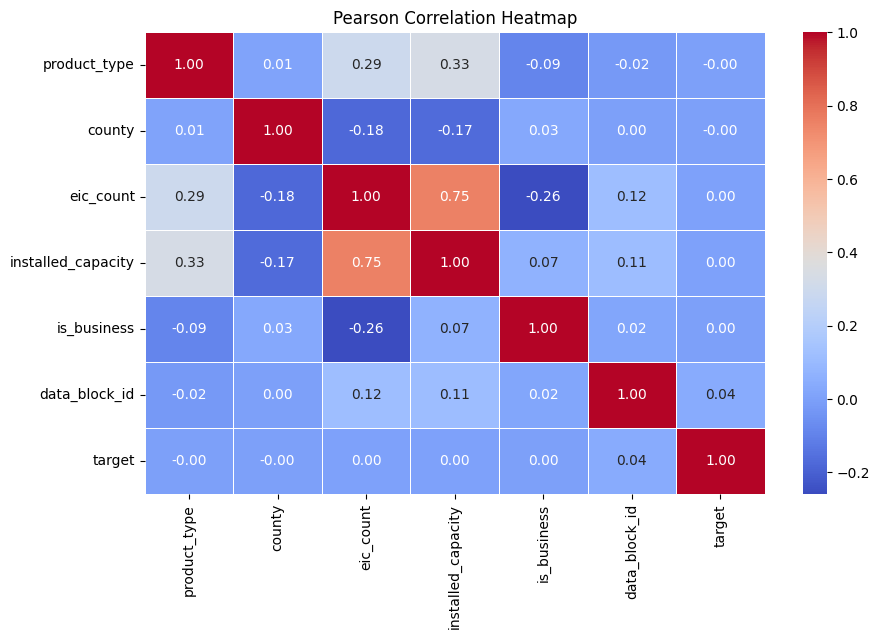

Our approach is to simplify the dataset by ignoring missing or less relevant features, allowing the model to focus on key variables that drive the target. We want to enhance the model's ability to capture linear behaviors by keeping only the most relevant data.

### **Step 1: Focus on Time-Related Features**
- **Date Columns:**  
  Most date columns don’t add much value beyond what the data block ID already captures (i.e., the day the data was made public).  
- **Hour Component:**  
  The hour of the day, however, is crucial because it contains cyclical information—energy consumption and production often follow daily cycles.

### **Step 2: Transform the Hour Feature**
- **Cyclical Encoding:**  
  To capture the cyclical nature of time, we'll create new features using the cosine and sine transformations of the hour. This approach helps the model understand that the end of the day connects back to the beginning (e.g., 23:00 and 00:00 are close in time).

By applying these transformations, the model can learn the periodic patterns inherent in the data, leading to more robust predictions.


In [26]:
train_df.sample()


,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
933281,4,1,0,204.193,1,2022-06-27 12:00:00,299,933281,17


In [27]:
import pandas as pd
import numpy as np

# Assuming your DataFrame is called 'df' and timestamp column is 'timestamp'
# If your column is not already datetime type, convert it
train_df['datetime'] = pd.to_datetime(train_df['datetime'])

# Extract hour from timestamp
train_df['hour'] = train_df['datetime'].dt.hour

# Apply cyclical encoding to hour
train_df['hour_sin'] = np.sin(2 * np.pi * train_df['hour']/24)
train_df['hour_cos'] = np.cos(2 * np.pi * train_df['hour']/24)

In [28]:
# what about the week and the month we will assium that is big diffrent since the are in way or another related to the how wither and where the pepole tend to make change on there behvior

# Day of week (0-6)
train_df['day_of_week'] = train_df['datetime'].dt.dayofweek
train_df['dow_sin'] = np.sin(2 * np.pi * train_df['day_of_week']/7)
train_df['dow_cos'] = np.cos(2 * np.pi * train_df['day_of_week']/7)

# Month (1-12)
train_df['month'] = train_df['datetime'].dt.month
train_df['month_sin'] = np.sin(2 * np.pi * (train_df['month']-1)/12)
train_df['month_cos'] = np.cos(2 * np.pi * (train_df['month']-1)/12)

# Day of month
train_df['day'] = train_df['datetime'].dt.day
train_df['day_sin'] = np.sin(2 * np.pi * (train_df['day']-1)/31)  # Using 31 as max days
train_df['day_cos'] = np.cos(2 * np.pi * (train_df['day']-1)/31)

In [33]:
common_columns = ['product_type', 'county', 'is_business', 'data_block_id']

# Merge the dataframes on common columns
merged_df = pd.merge(
    train_df,
    client_df.drop(columns=["date"]),
    on=common_columns,
    how='inner'  # Use inner join to keep only matching rows
)

In [35]:
merged_df.head(2)

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,hour,...,dow_sin,dow_cos,month,month_sin,month_cos,day,day_sin,day_cos,eic_count,installed_capacity
0,0,0,1,0.793,0,2021-09-03,2,5856,0,0,...,-0.433884,-0.900969,9,-0.866025,-0.5,3,0.394356,0.918958,108,952.89
1,0,0,1,107.129,1,2021-09-03,2,5857,0,0,...,-0.433884,-0.900969,9,-0.866025,-0.5,3,0.394356,0.918958,108,952.89


The next step is to examine the forecasting data—such as gas prices and other forecasted variables—to evaluate its accuracy. Our goal is to determine if the forecast data reliably describes the next day’s conditions. If the forecast data proves accurate, we might choose to exclude it from our feature set, assuming that users trust these forecasts to make informed decisions.

In [10]:
historical_weather.head()
electricity_prices_df.head()

,forecast_date,euros_per_mwh,origin_date,data_block_id
0,2021-09-01 00:00:00,92.51,2021-08-31 00:00:00,1
1,2021-09-01 01:00:00,88.90,2021-08-31 01:00:00,1
2,2021-09-01 02:00:00,87.35,2021-08-31 02:00:00,1
3,2021-09-01 03:00:00,86.88,2021-08-31 03:00:00,1
4,2021-09-01 04:00:00,88.43,2021-08-31 04:00:00,1


In [25]:
forecast_weather_df["origin_date"] = forecast_weather_df["origin_datetime"]  # origin_date

In [27]:
forecast = forecast_weather_df.drop(columns=["origin_datetime","longitude","latitude"])

In [36]:
import pandas as pd
from sklearn.feature_selection import mutual_info_regression

# Assuming 'data_block_id' is a common column
merged = pd.merge(forecast, electricity_prices_df, on='origin_date', how='inner')
X = merged.drop(columns=['euros_per_mwh','origin_date',"forecast_date","forecast_datetime"])
y = merged['euros_per_mwh'].dropna() # Call dropna() to remove NaN values before using it


In [43]:
merged.dropna(inplace=True)
X = merged.drop(columns=['euros_per_mwh','origin_date',"forecast_date","forecast_datetime"])
y = merged['euros_per_mwh'].dropna()

In [44]:
from sklearn.feature_selection import mutual_info_regression
mi_scores = mutual_info_regression(X,y, random_state=42) # Pass the cleaned 'y' array
mi_df = pd.DataFrame({
    'feature': X.columns,
    'mi_score': mi_scores
}).sort_values('mi_score', ascending=False)

**forecast_weather_df vs electricity**




In [45]:
mi_df

,feature,mi_score
9,data_block_id_x,6.412422
14,data_block_id_y,6.411619
2,dewpoint,1.219679
6,cloudcover_total,1.153785
1,temperature,1.131631
4,cloudcover_low,0.996990
13,total_precipitation,0.552402
5,cloudcover_mid,0.538021
7,10_metre_u_wind_component,0.523845
8,10_metre_v_wind_component,0.489214


**historical_weather vs electricity**

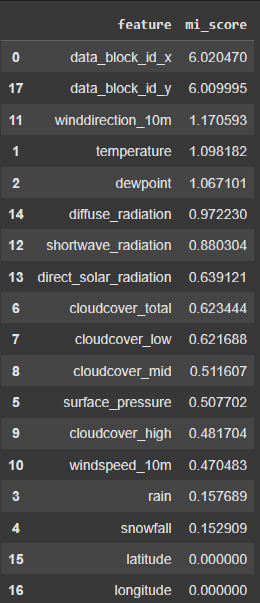

In [70]:
mi_df # target vs historical_weather

,feature,mi_score
21,prediction_unit_id,0.499420
19,is_consumption,0.282466
20,row_id,0.208902
16,county,0.147863
18,product_type,0.121201
1,latitude,0.120825
2,longitude,0.120751
22,hour,0.079966
0,data_block_id,0.079237
4,temperature,0.075124


In [36]:
historical_data = historical_weather[["winddirection_10m","temperature","dewpoint","diffuse_radiation","shortwave_radiation","data_block_id"]]

In [37]:
forecast_data = forecast_weather_df[["dewpoint","cloudcover_total","temperature","data_block_id"]]

In [38]:
historical_data = historical_data.groupby(['data_block_id']).mean()
forecast_data = forecast_data.groupby(['data_block_id']).mean()

In [39]:
merged_df.head(3)

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,hour,...,dow_sin,dow_cos,month,month_sin,month_cos,day,day_sin,day_cos,eic_count,installed_capacity
0,0,0,1,0.793,0,2021-09-03,2,5856,0,0,...,-0.433884,-0.900969,9,-0.866025,-0.5,3,0.394356,0.918958,108,952.89
1,0,0,1,107.129,1,2021-09-03,2,5857,0,0,...,-0.433884,-0.900969,9,-0.866025,-0.5,3,0.394356,0.918958,108,952.89
2,0,0,2,0.000,0,2021-09-03,2,5858,1,0,...,-0.433884,-0.900969,9,-0.866025,-0.5,3,0.394356,0.918958,17,166.40


In [40]:
def df(data):
  data = data.drop(columns =[ "origin_date","forecast_date"])
  data = data.groupby(['data_block_id']).mean()
  data.reset_index(inplace=True)
  #data.rename(columns={'data_block_id': 'date'}, inplace=True
  return data

electricity_prices = df(electricity_prices_df)

In [41]:
def restindex(data):
  data.reset_index(inplace=True)
  return data
restindex(forecast_data)
restindex(historical_data)

,data_block_id,winddirection_10m,temperature,dewpoint,diffuse_radiation,shortwave_radiation
0,1.0,327.261364,13.265747,10.352760,32.348214,86.035714
1,2.0,327.412202,12.273996,6.688951,54.344494,167.158854
2,3.0,298.128720,12.688690,7.780469,57.733631,138.675223
3,4.0,325.011905,10.488244,5.003906,53.777902,165.282366
4,5.0,319.408854,9.670461,4.280580,58.438616,166.859375
...,...,...,...,...,...,...
632,633.0,274.333705,13.719754,6.250521,89.706845,242.926339
633,634.0,297.412574,11.127641,3.180618,72.562872,268.952009
634,635.0,241.424107,11.046205,2.253609,71.278274,296.167039
635,636.0,242.921503,12.991257,5.869159,75.354167,285.602307


In [42]:
final_data = pd.merge(
    forecast_data,
    historical_data,
    on="data_block_id",
    how='inner'  # Use inner join to keep only matching rows
)

In [43]:
final_data_1 = pd.merge(
    electricity_prices,
    merged_df,
    on="data_block_id",
    how='inner'  # Use inner join to keep only matching rows
)


final = pd.merge(
    final_data_1,
    final_data,
    on="data_block_id",
    how='inner'  # Use inner join to keep only matching rows
)


# Energy Consumption and Production Forecasting

In this notebook, we aim to develop predictive models for energy consumption and production using a dataset enriched with temporal, client-specific, and weather-related features. Our approach involves:

1. **Feature Engineering**:
   - **Temporal Features**: We transform time-related data into cyclical representations (e.g., sine and cosine transformations) to capture the periodic nature of energy usage patterns.
   - **Client Characteristics**: Incorporating attributes such as business type (`is_business`), product type (`product_type`), number of energy installations (`eic_count`), and installed capacity (`installed_capacity`) to account for client-specific energy behaviors.
   - **Weather Features**: Including meteorological variables like temperature (`temperature_x`, `temperature_y`), dew point (`dewpoint_x`, `dewpoint_y`), cloud cover (`cloudcover_total`), diffuse radiation (`diffuse_radiation`), and shortwave radiation (`shortwave_radiation`) to assess environmental impacts on energy dynamics.

2. **Segmentation**:
   - We differentiate between consumption and production data, acknowledging that each follows distinct patterns and may require separate modeling strategies.

3. **Model Development**:
   - Utilizing a Gradient Boosting Regressor, known for its robustness in handling complex datasets, to predict energy metrics.
   - Implementing data scaling through `StandardScaler` to normalize feature distributions, ensuring optimal model performance.

4. **Model Evaluation**:
   - Assessing model accuracy using Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE) metrics.
   - Identifying key predictors by analyzing feature importances derived from the trained model.

This structured methodology not only enhances the predictive accuracy but also provides valuable insights into the factors influencing energy consumption and production, facilitating data-driven decision-making in energy management.


In [44]:
final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2009712 entries, 0 to 2009711
Data columns (total 32 columns):
 #   Column               Dtype         
---  ------               -----         
 0   data_block_id        int64         
 1   euros_per_mwh        float64       
 2   county               int64         
 3   is_business          int64         
 4   product_type         int64         
 5   target               float64       
 6   is_consumption       int64         
 7   datetime             datetime64[ns]
 8   row_id               int64         
 9   prediction_unit_id   int64         
 10  hour                 int32         
 11  hour_sin             float64       
 12  hour_cos             float64       
 13  day_of_week          int32         
 14  dow_sin              float64       
 15  dow_cos              float64       
 16  month                int32         
 17  month_sin            float64       
 18  month_cos            float64       
 19  day                  

In [49]:
df = final.dropna()
df = df.drop(columns=["row_id"])
df.head(2)

,data_block_id,euros_per_mwh,county,is_business,product_type,target,is_consumption,datetime,prediction_unit_id,hour,...,eic_count,installed_capacity,dewpoint_x,cloudcover_total,temperature_x,winddirection_10m,temperature_y,dewpoint_y,diffuse_radiation,shortwave_radiation
0,2,112.63125,0,0,1,0.793,0,2021-09-03,0,0,...,108,952.89,6.729556,0.535103,12.107136,327.412202,12.273996,6.688951,54.344494,167.158854
1,2,112.63125,0,0,1,107.129,1,2021-09-03,0,0,...,108,952.89,6.729556,0.535103,12.107136,327.412202,12.273996,6.688951,54.344494,167.158854


In [50]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt


In [89]:
# 1. Feature selection based on physics understanding
features = ['hour_sin',
 'hour_cos',
 'dow_sin',
 'dow_cos',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'is_business',
 'product_type',
 'eic_count',
 'installed_capacity',
 'euros_per_mwh',
 'temperature_x',
 'temperature_y',
 'dewpoint_x',
 'dewpoint_y',
 'cloudcover_total',
 'diffuse_radiation',
 'shortwave_radiation',
 'temp_gradient',
 'effective_solar',
 'temp_comfort_distance',
 'generation_potential']



#[
    # Time features (cyclical)
#    'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos',

    # Client characteristics
 #   'is_business', 'product_type', 'eic_count', 'installed_capacity','euros_per_mwh',

    # Weather features (energy transfer related)
#    'temperature_x', 'temperature_y', 'dewpoint_x', 'dewpoint_y',
#    'cloudcover_total', 'diffuse_radiation', 'shortwave_radiation'
#]

In [90]:
df[features].info()

<class 'pandas.core.frame.DataFrame'>
Index: 2009184 entries, 0 to 2009711
Data columns (total 24 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   hour_sin               float32
 1   hour_cos               float32
 2   dow_sin                float32
 3   dow_cos                float32
 4   month_sin              float32
 5   month_cos              float32
 6   day_sin                float32
 7   day_cos                float32
 8   is_business            int8   
 9   product_type           int8   
 10  eic_count              int16  
 11  installed_capacity     float32
 12  euros_per_mwh          float32
 13  temperature_x          float32
 14  temperature_y          float32
 15  dewpoint_x             float32
 16  dewpoint_y             float32
 17  cloudcover_total       float32
 18  diffuse_radiation      float32
 19  shortwave_radiation    float32
 20  temp_gradient          float32
 21  effective_solar        float32
 22  temp_comfort_distance  

In [61]:
df['is_business'] = pd.to_numeric(df['is_business'], downcast='integer')
df['product_type'] = pd.to_numeric(df['product_type'], downcast='integer')
df['eic_count'] = pd.to_numeric(df['eic_count'], downcast='integer')


float_cols = ['installed_capacity', 'euros_per_mwh', 'temperature_x', 'temperature_y',
              'dewpoint_x', 'dewpoint_y', 'cloudcover_total', 'diffuse_radiation',
              'shortwave_radiation']
df[float_cols] = df[float_cols].astype('float32')


time_cols = ['hour_sin', 'hour_cos', 'dow_sin', 'dow_cos',
             'month_sin', 'month_cos', 'day_sin', 'day_cos']
df[time_cols] = df[time_cols].astype('float32')



print(df.info(memory_usage='deep'))


<class 'pandas.core.frame.DataFrame'>
Index: 2009184 entries, 0 to 2009711
Data columns (total 31 columns):
 #   Column               Dtype         
---  ------               -----         
 0   data_block_id        int64         
 1   euros_per_mwh        float32       
 2   county               int64         
 3   is_business          int8          
 4   product_type         int8          
 5   target               float64       
 6   is_consumption       int64         
 7   datetime             datetime64[ns]
 8   prediction_unit_id   int64         
 9   hour                 int32         
 10  hour_sin             float32       
 11  hour_cos             float32       
 12  day_of_week          int32         
 13  dow_sin              float32       
 14  dow_cos              float32       
 15  month                int32         
 16  month_sin            float32       
 17  month_cos            float32       
 18  day                  int32         
 19  day_sin              float

In [62]:
# Create separate models for consumption and production (they follow different physics)
df_consumption = df[df['is_consumption'] == 1]
df_production = df[df['is_consumption'] == 0]

In [63]:
# Function to build and evaluate model
def build_energy_model(data, features, target_col='target'):
    X = data[features]
    y = data[target_col]

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale features (important for energy-related variables with different units)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train model - GBM works well for energy prediction
    model = GradientBoostingRegressor(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=5,
        random_state=42
    )
    model.fit(X_train_scaled, y_train)

    # Evaluate model
    y_pred = model.predict(X_test_scaled)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    # Get feature importances
    importances = pd.DataFrame({
        'feature': features,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)

    return model, scaler, mae, rmse, importances, y_test, y_pred

In [64]:


# Build consumption model
cons_model, cons_scaler, cons_mae, cons_rmse, cons_importances, cons_y_test, cons_y_pred = build_energy_model(df_consumption, features)

# Build production model (if applicable)
if len(df_production) > 0:
    prod_model, prod_scaler, prod_mae, prod_rmse, prod_importances ,prod_y_test, prod_y_pred = build_energy_model(df_production, features)

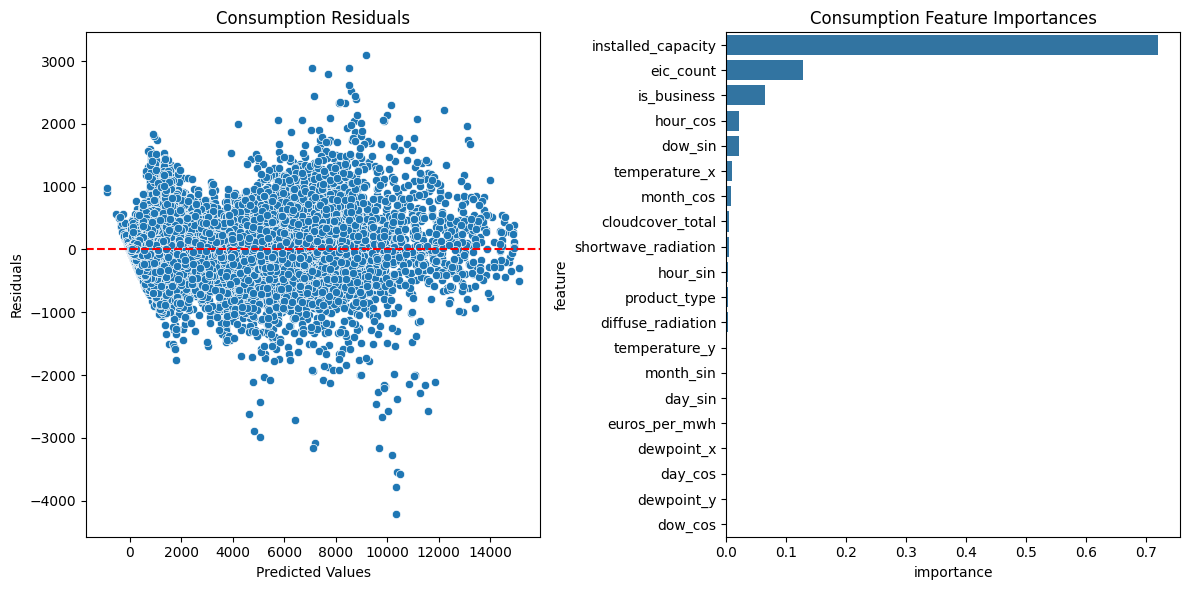

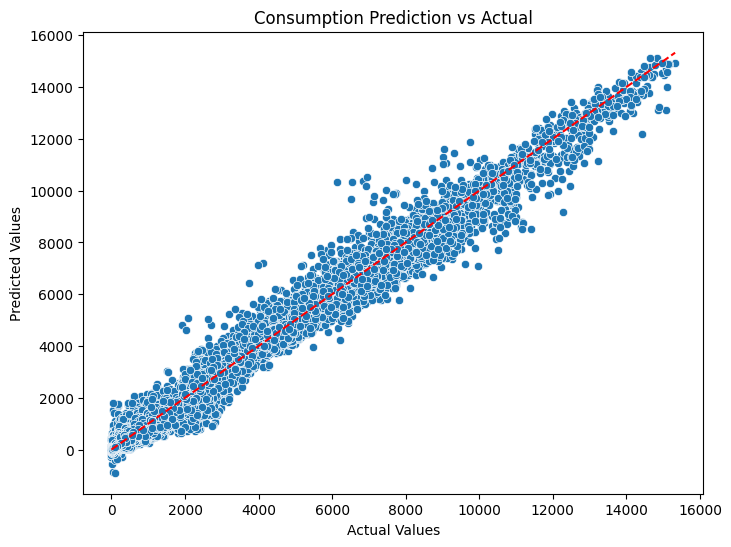

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Function to plot residuals and feature importances
def evaluate_model_performance(y_test, y_pred, importances, model_type='Model'):
    # Residuals
    residuals = y_test - y_pred
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.scatterplot(x=y_pred, y=residuals)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(f'{model_type} Residuals')

    # Feature Importances
    plt.subplot(1, 2, 2)
    sns.barplot(x='importance', y='feature', data=importances)
    plt.title(f'{model_type} Feature Importances')
    plt.tight_layout()
    plt.show()

    # Prediction vs Actual
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_test, y=y_pred)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'{model_type} Prediction vs Actual')
    plt.show()

# Evaluate consumption model
evaluate_model_performance(cons_y_test, cons_y_pred, cons_importances, model_type='Consumption')



In [76]:
# Display performance metrics for the consumption model
print("Consumption Model Performance:")
print(f"Mean Absolute Error (MAE): {cons_mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {cons_rmse:.4f}")



Consumption Model Performance:
Mean Absolute Error (MAE): 78.7357
Root Mean Squared Error (RMSE): 161.0875


In [78]:
cons_importances

,feature,importance
11,installed_capacity,0.720109
10,eic_count,0.128015
8,is_business,0.064307
1,hour_cos,0.022430
2,dow_sin,0.021948
13,temperature_x,0.009813
5,month_cos,0.008512
17,cloudcover_total,0.004826
19,shortwave_radiation,0.004600
0,hour_sin,0.004046


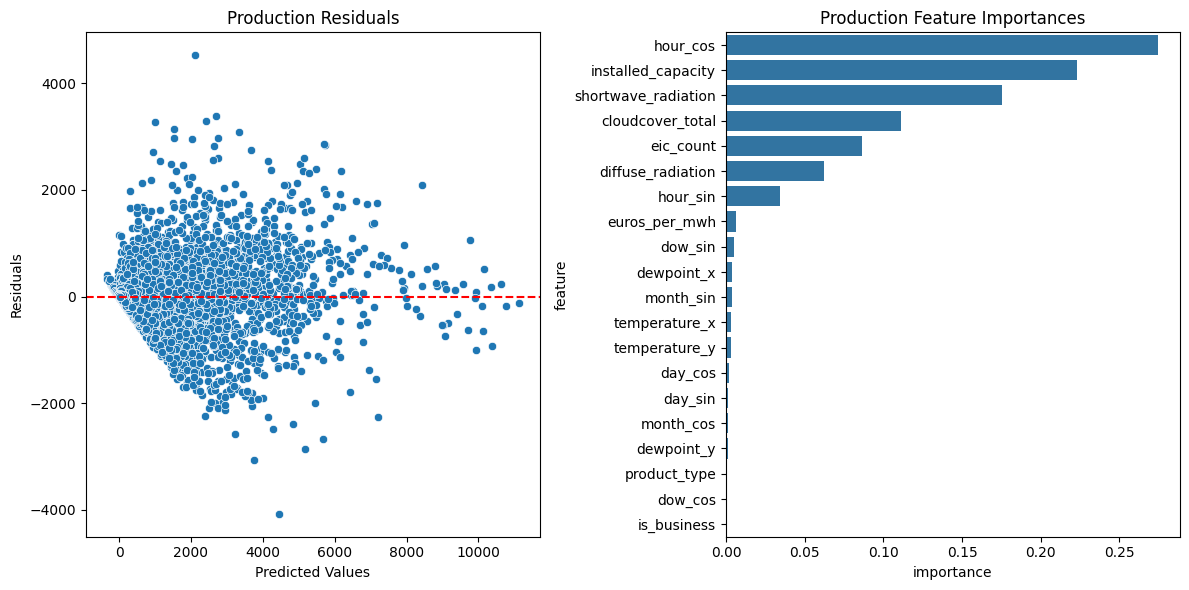

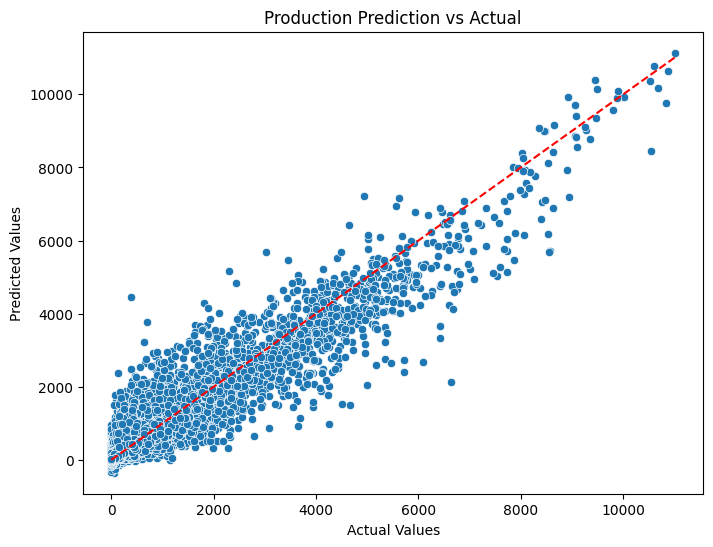

In [69]:
# Evaluate production model if it exists
if 'prod_y_test' in locals() and 'prod_y_pred' in locals():
    evaluate_model_performance(prod_y_test, prod_y_pred, prod_importances, model_type='Production')

In [77]:
# If the production model exists, display its performance metrics
if 'prod_mae' in locals():
    print("\nProduction Model Performance:")
    print(f"Mean Absolute Error (MAE): {prod_mae:.4f}")
    print(f"Root Mean Squared Error (RMSE): {prod_rmse:.4f}")


Production Model Performance:
Mean Absolute Error (MAE): 34.8222
Root Mean Squared Error (RMSE): 111.1893


In [110]:
prod_importances

,feature,importance
1,hour_cos,0.275481
11,installed_capacity,0.224354
18,shortwave_radiation,0.179731
16,cloudcover_total,0.112308
10,eic_count,0.089356
17,diffuse_radiation,0.056031
0,hour_sin,0.035177
14,dewpoint_x,0.005466
2,dow_sin,0.005013
4,month_sin,0.004036


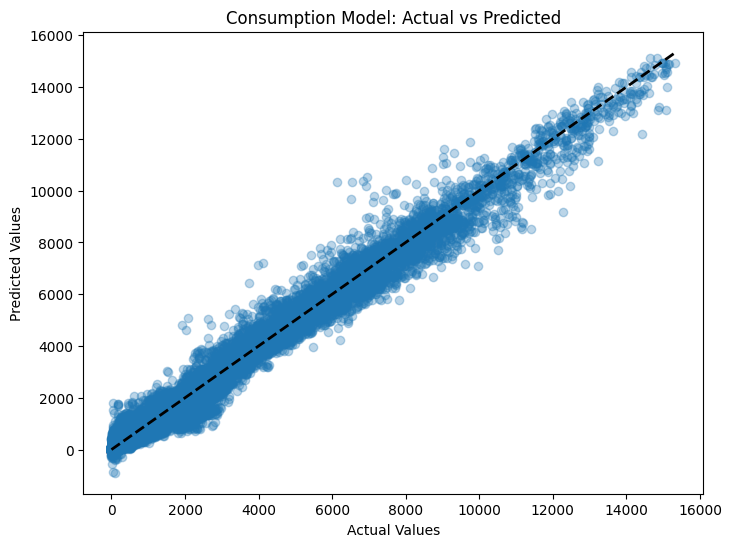

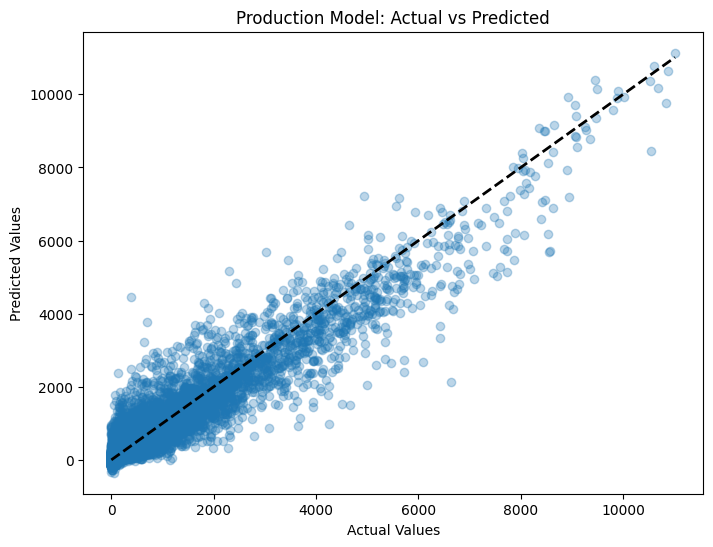

In [80]:
# Function to plot actual vs predicted values
def plot_actual_vs_predicted(y_test, y_pred, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.3)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(title)
    plt.show()

# Plot for the consumption model
plot_actual_vs_predicted(cons_y_test, cons_y_pred, "Consumption Model: Actual vs Predicted")

# If the production model exists, plot for it
if 'prod_y_test' in locals() and 'prod_y_pred' in locals():
    plot_actual_vs_predicted(prod_y_test, prod_y_pred, "Production Model: Actual vs Predicted")


In [82]:
# Function to display model summary
def display_model_summary(model, model_name):
    print(f"{model_name} Summary:")
    print(f"Number of Estimators: {model.n_estimators}")
    print(f"Learning Rate: {model.learning_rate}")
    print(f"Max Depth: {model.max_depth}")
    print("-" * 40)

# Display summaries for both models
display_model_summary(cons_model, "Consumption Model")

if 'prod_model' in locals():
    display_model_summary(prod_model, "Production Model")


Consumption Model Summary:
Number of Estimators: 200
Learning Rate: 0.1
Max Depth: 5
----------------------------------------
Production Model Summary:
Number of Estimators: 200
Learning Rate: 0.1
Max Depth: 5
----------------------------------------


In [83]:
import os
model_dir = '/content/drive/MyDrive/ColabModels'
os.makedirs(model_dir, exist_ok=True)


In [84]:
import joblib

# Save the consumption model and its scaler
cons_model_path = os.path.join(model_dir, 'consumption_model.pkl')
cons_scaler_path = os.path.join(model_dir, 'consumption_scaler.pkl')
joblib.dump(cons_model, cons_model_path)
joblib.dump(cons_scaler, cons_scaler_path)

# Save the production model and its scaler, if applicable
if 'prod_model' in locals():
    prod_model_path = os.path.join(model_dir, 'production_model.pkl')
    prod_scaler_path = os.path.join(model_dir, 'production_scaler.pkl')
    joblib.dump(prod_model, prod_model_path)
    joblib.dump(prod_scaler, prod_scaler_path)
